In [1]:
from pathlib import Path
import sys
import os


current_file_path = Path(os.path.abspath('')).resolve()
# print(current_file_path.parent)
sys.path.insert(0, str(current_file_path.parent))

In [2]:
from tqdm import tqdm
from PIL import Image, ImageFile
from src.utils.misc import read_config
from src.slot_attention import UOD

/home/scai/phd/aiz228170/.conda/envs/pixart/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
import os
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch

In [4]:
config_file = '../configs/our_config.py'
config = read_config(config_file)
model = UOD(config)


model = model.eval()
device = "cuda:0"

In [5]:
CKPT_PATH = '/scratch/cse/btech/cs1210561/SA/output/clevr_run_res112/checkpoints/epoch_468_step_524999.pth'
checkpoint = torch.load(CKPT_PATH)
model.load_state_dict(checkpoint['state_dict'])
model = model.eval()
model = model.to(device)

In [6]:
import pickle
with open("/scratch/cse/btech/cs1210561/SA/image_slots_val_dump.pkl", 'rb') as f:
    slots = pickle.load(f)

In [7]:
slot = slots[0]['slots'][None,:]
slot.shape

(1, 9, 64)

In [8]:
op_dct = model.slot_to_img(torch.tensor(slot).to(device))

In [9]:
op_dct.keys()

dict_keys(['generated', 'content', 'masks'])

In [14]:
def unnormalize(images):
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(-1).unsqueeze(-1)
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(-1).unsqueeze(-1)
 
    images = images*std.to(images.device)
    images = images + mean.to(images.device)
    return images


def image_from_tensor(image):
    image = image.permute(1,2,0)
    # image = (image + 1)/2
    image = image*255
    image = image.cpu().detach().numpy()
    image = image.astype('uint8')
    image = Image.fromarray(image)
    return image


color_map = torch.tensor([
    [1., 0, 0],     # Object 1 (Red)
    [0., 1, 0],     # Object 2 (Green)
    [0, 0., 1],     # Object 3 (Blue)
    [1, 1., 0],   # Object 4 (Yellow)
    [1, 0., 1],   # Object 5 (Magenta)
    [0, 1, 1.],   # Object 6 (Cyan)
    [0.5, 0.5, 0.5], # Object 7 (Gray)
    [1, 0.5, 0],   # Object 8 (Orange)
    [0.5, 0, 0.5],   # Object 9 (Purple)
])


def create_colored_combined_mask(combined_mask):

    h, w = combined_mask.shape
    num_slots = len(color_map)
    
    colored_mask = torch.zeros((h, w, 3), device=combined_mask.device)
    
    for slot_idx in range(num_slots):
        slot_mask = (combined_mask == slot_idx).unsqueeze(-1).float()  # Shape: [H, W, 1]

        color_map_cuda = color_map.to(combined_mask.device)
        
        colored_mask += slot_mask * color_map_cuda[slot_idx].view(1, 1, 3)  # Broadcasting for RGB channels
    colored_mask = colored_mask*255
    colored_mask = colored_mask.cpu().detach().numpy()
    colored_mask = colored_mask.astype('uint8')
    colored_mask = Image.fromarray(colored_mask)
    return colored_mask

In [15]:
G = unnormalize(op_dct['generated'])

In [16]:
Ig = image_from_tensor(G.squeeze(0))

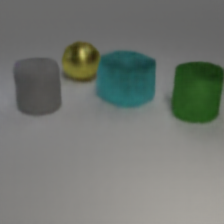

In [17]:
Ig

In [18]:
combined_masks = op_dct['masks'].argmax(1)[:,0] 

In [19]:
combined_masks.shape

torch.Size([1, 224, 224])

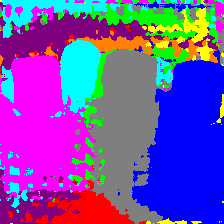

In [20]:
create_colored_combined_mask(combined_masks[0])

In [21]:
import matplotlib.pyplot as plt

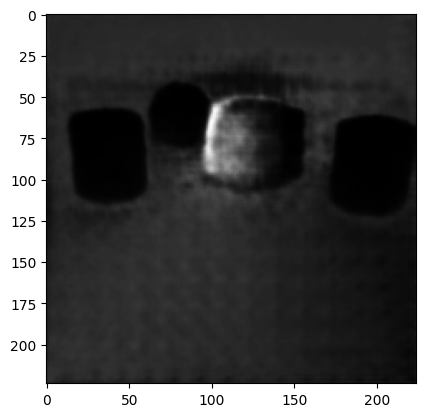

In [22]:
plt.imshow(op_dct['masks'][0][1].squeeze().cpu().detach().numpy(), cmap='gray')

In [25]:
import numpy as np
(op_dct['masks'][0][1].squeeze().cpu().detach().numpy()*255).astype(np.uint8).repeat((1,1,3)).shape

ValueError: operands could not be broadcast together with shape (50176,) (3,)

In [ ]:
image_from_tensor(op_dct['masks'][0][1])